## Demonstrating the TimeComponent Class
This section demonstrates how to use the `TimeComponent` class directly for defining and manipulating time structures in energy system scenarios. We'll show two different setups: a uniform time structure and a more complex, non-uniform structure.

### 1. Import and Setup
First, import the class and set up a clean output directory for the demonstration.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

### 2. Uniform Time Structure Example
Let's create a simple, uniform time structure with 3 years, 2 seasons, 2 day types, and 2 daily time brackets.

In [2]:
from pyoscomp.scenario.components.time import TimeComponent
from pyoscomp.scenario.visualization import TimeVisualizer

import shutil
# Set up a clean demo output directory
DEMO_DIR = "demo_output/time_component"
if os.path.exists(DEMO_DIR):
    shutil.rmtree(DEMO_DIR)
os.makedirs(DEMO_DIR, exist_ok=True)

In [3]:
# --- Uniform Time Structure ---
uniform_dir = os.path.join(DEMO_DIR, "uniform")
os.makedirs(uniform_dir, exist_ok=True)

# Define time structure parameters
years = (2025, 2050, 5)  # start, end, step
seasons = {"Winter": 182, "Summer": 183}  # 365 days total
daytypes = {"Weekday": 5, "Weekend": 2}
brackets = {"Day": 12, "Night": 12}  # 24 hours total

# Create and configure the TimeComponent
time_uniform = TimeComponent(uniform_dir)
time_uniform.add_time_structure(years, seasons, daytypes, brackets)
time_uniform.save()  # Save to CSV

# Display the generated DataFrames
print("Years:")
print(time_uniform.years_df)
print("Timeslices:")
print(time_uniform.timeslices_df)
print("Seasons:")
print(time_uniform.seasons_df)
print("Daytypes:")
print(time_uniform.daytypes_df)
print("Brackets:")
print(time_uniform.brackets_df)

Years:
   VALUE
0   2025
1   2030
2   2035
3   2040
4   2045
5   2050
Timeslices:
                  VALUE
0    Winter_Weekday_Day
1  Winter_Weekday_Night
2    Winter_Weekend_Day
3  Winter_Weekend_Night
4    Summer_Weekday_Day
5  Summer_Weekday_Night
6    Summer_Weekend_Day
7  Summer_Weekend_Night
Seasons:
    VALUE
0  Winter
1  Summer
Daytypes:
     VALUE
0  Weekday
1  Weekend
Brackets:
   VALUE
0    Day
1  Night


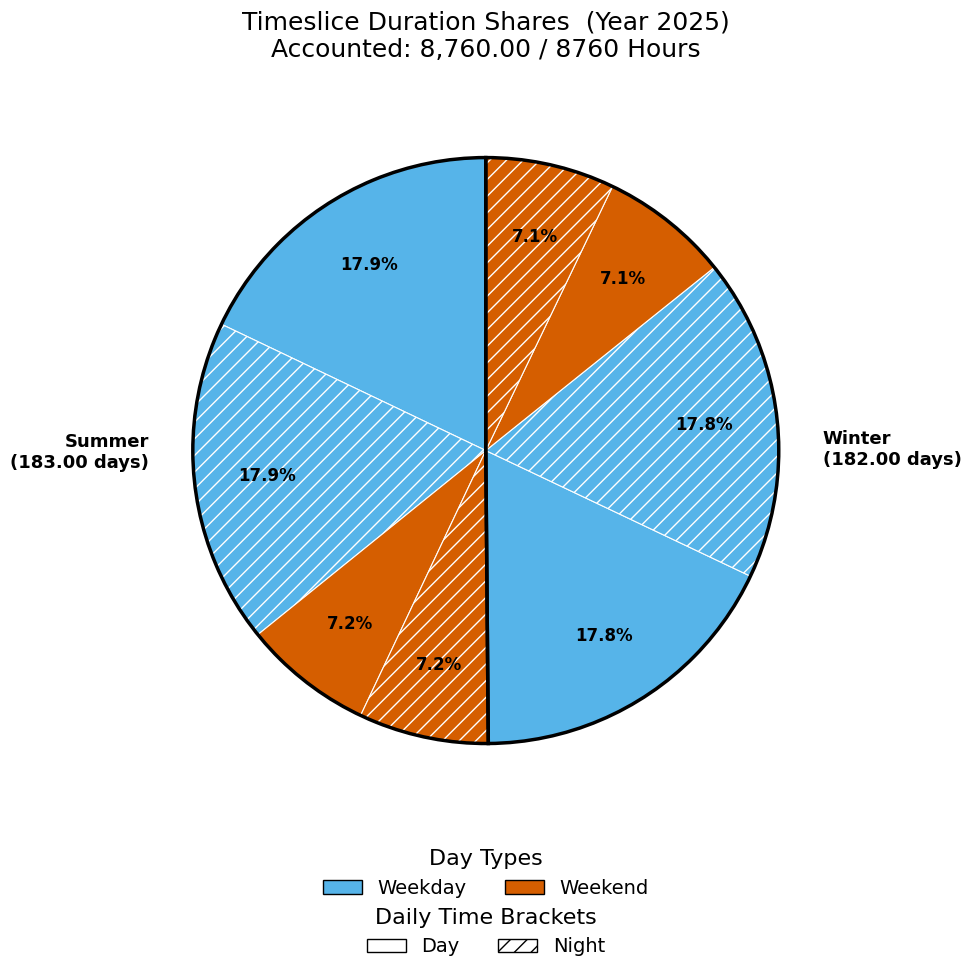

In [10]:
# Visualize the uniform scenario
time_uniform = TimeComponent(uniform_dir)  # Load from CSV
time_uniform.load()

viz = TimeVisualizer(time_uniform)
fig, ax = viz.plot_duration_pie(year = 2025)

### 3. Complex (Non-Uniform) Time Structure Example
Now, let's create a more complex time structure with irregular season lengths, custom day types, and non-uniform daily brackets.

In [5]:
# --- Complex Time Structure ---
complex_dir = os.path.join(DEMO_DIR, "complex")
os.makedirs(complex_dir, exist_ok=True)

# Define time structure parameters
years_complex = (2025, 2055, 5)  # 2025, 2030, 2035
seasons_complex = {"Winter": 90, "Summer": 90, "Shoulder": 185}
daytypes_complex = {"Normal": 0.9, "Peak": 0.09, "SuperPeak": 0.01}
brackets_complex = {"Base": 18, "Ramp": 4, "PeakHour": 1.9, "CriticalHour": 0.1}

# Create and configure the TimeComponent
time_complex = TimeComponent(complex_dir)
time_complex.add_time_structure(years_complex, seasons_complex, daytypes_complex, brackets_complex)
time_complex.save()

# Display the generated DataFrames
print("Years (Complex):")
print(time_complex.years_df)
print("Timeslices (Complex):")
print(time_complex.timeslices_df)
print("Seasons (Complex):")
print(time_complex.seasons_df)
print("Daytypes (Complex):")
print(time_complex.daytypes_df)
print("Brackets (Complex):")
print(time_complex.brackets_df)

Years (Complex):
   VALUE
0   2025
1   2030
2   2035
3   2040
4   2045
5   2050
6   2055
Timeslices (Complex):
                              VALUE
0                Winter_Normal_Base
1                Winter_Normal_Ramp
2            Winter_Normal_PeakHour
3        Winter_Normal_CriticalHour
4                  Winter_Peak_Base
5                  Winter_Peak_Ramp
6              Winter_Peak_PeakHour
7          Winter_Peak_CriticalHour
8             Winter_SuperPeak_Base
9             Winter_SuperPeak_Ramp
10        Winter_SuperPeak_PeakHour
11    Winter_SuperPeak_CriticalHour
12               Summer_Normal_Base
13               Summer_Normal_Ramp
14           Summer_Normal_PeakHour
15       Summer_Normal_CriticalHour
16                 Summer_Peak_Base
17                 Summer_Peak_Ramp
18             Summer_Peak_PeakHour
19         Summer_Peak_CriticalHour
20            Summer_SuperPeak_Base
21            Summer_SuperPeak_Ramp
22        Summer_SuperPeak_PeakHour
23    Summer_SuperPeak_Cr

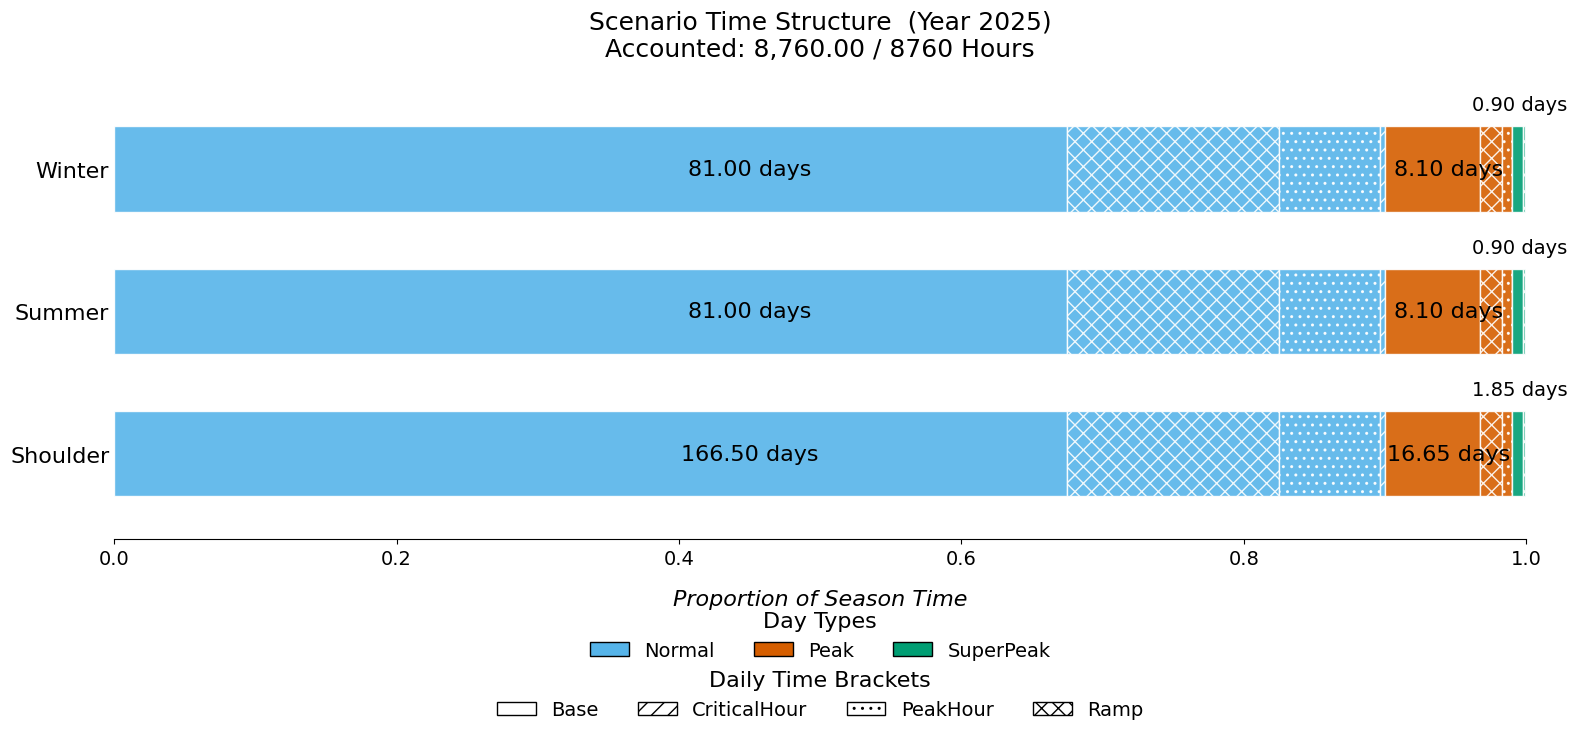

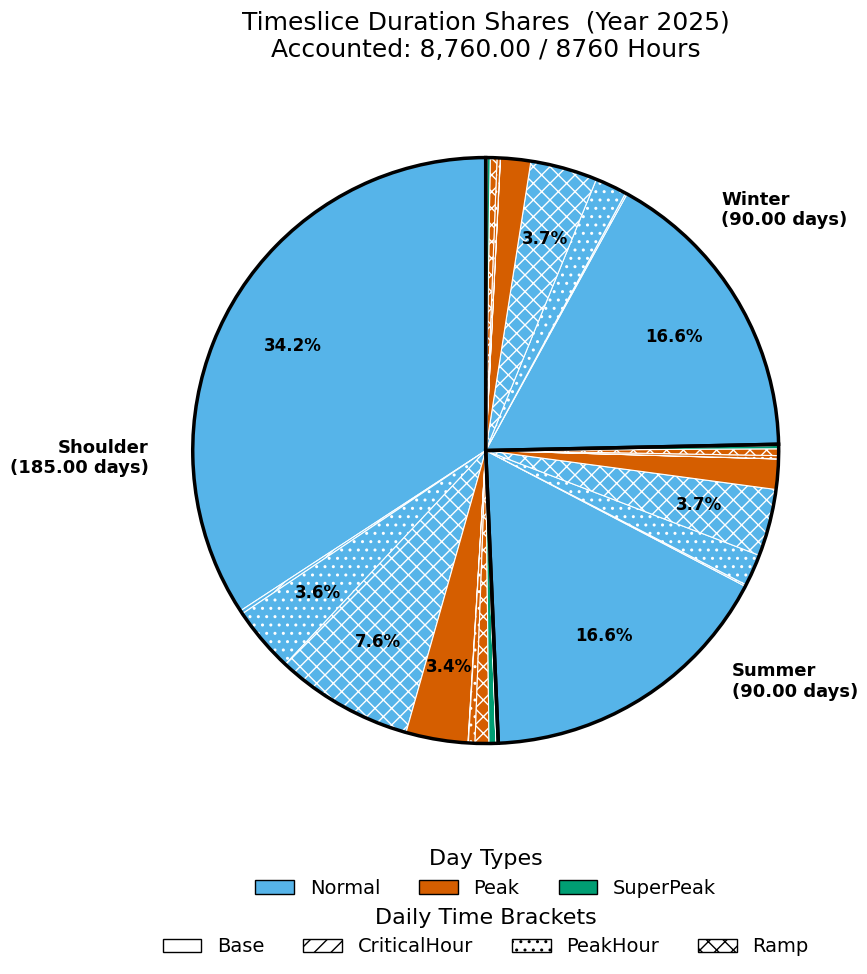

In [11]:
# Visualize the complex scenario
time_complex = TimeComponent(complex_dir)  # Load from CSV
time_complex.load()

viz = TimeVisualizer(time_complex)
viz.show()
fig, ax = viz.plot_duration_pie(year = 2025)  # alternative view

### 4. Loading and Validating from CSVs
You can reload the time structure from CSV files to validate persistence and correctness.

In [7]:
# Reload the uniform scenario from CSVs to validate persistence
time_uniform_reloaded = TimeComponent(uniform_dir)
time_uniform_reloaded.load()
print("Reloaded Years (Uniform):")
print(time_uniform_reloaded.years_df)
print("Reloaded Brackets (Uniform):")
print(time_uniform_reloaded.brackets_df)
print("Reloaded Timeslices (Uniform):")
print(time_uniform_reloaded.timeslices_df.head())
print("Reloaded Seasons (Uniform):")
print(time_uniform_reloaded.seasons_df)
print("Reloaded Daytypes (Uniform):")
print(time_uniform_reloaded.daytypes_df)

Reloaded Years (Uniform):
   VALUE
0   2025
1   2030
2   2035
3   2040
4   2045
5   2050
Reloaded Brackets (Uniform):
   VALUE
0    Day
1  Night
Reloaded Timeslices (Uniform):
                  VALUE
0    Winter_Weekday_Day
1  Winter_Weekday_Night
2    Winter_Weekend_Day
3  Winter_Weekend_Night
4    Summer_Weekday_Day
Reloaded Seasons (Uniform):
    VALUE
0  Winter
1  Summer
Reloaded Daytypes (Uniform):
     VALUE
0  Weekday
1  Weekend


### 5. Summary
The `TimeComponent` class provides a flexible and robust way to define, modify, and persist time structures for energy system scenarios. You can easily set up both simple and complex time grids, inspect and edit the underlying data, and ensure all changes are saved and reloadable from CSV files.